In [63]:
from IPython.display import display
from PIL import Image
import pickle
from keras.applications import VGG16
from random import shuffle, seed
from keras import models
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences
import numpy as np
from keras import Input, Model
from keras.layers import Dropout, Dense, Embedding, LSTM, add
import os
import pickle
from keras.models import load_model

from ProjectApi import max_length

In [64]:
#Crated image dictionary , image names are keys and sentences are values as array
image_dic = {}
#took the data from data/captions.txt
with open('./data/captions.txt') as f:
    lines = f.readlines()
    for i in lines:
        #separated them from commas
        sentences = i.split(",")
        #if there is dict key exist added next sentence to value arrays
        if sentences[0] in image_dic.keys():
            image_dic[sentences[0]].append(i[len(sentences[0]) + 1:-3])
        #created dict item if isn't exist
        else:
            image_dic[sentences[0]] = [i[len(sentences[0]) + 1:-3]]

In [65]:
#creted function to see our created dictionary works fine
def show_image_and_captions(img_id):
    data = "data/images/" + img_id
    display(Image.open("./data/images/" + img_id))
    print("--------------------------Captions are--------------------------")
    for description in range(len(image_dic[img_id])):
        print(image_dic[img_id][description])

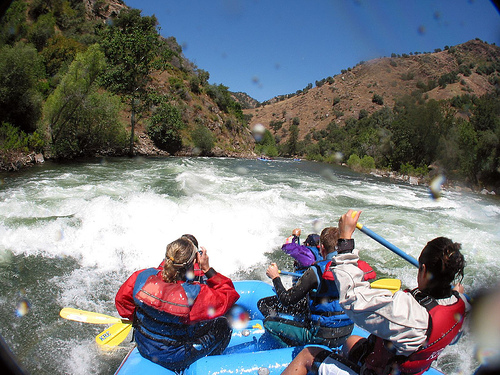

--------------------------Captions are--------------------------
A group of people on a blue raft going down a river
A group of people paddle their blue inflatable raft down the rapids
a group of people white water rafting in a blue raft
Several people are rafting down a choppy river in rocky terrain
Some people are riding a raft down a white water river


In [66]:
show_image_and_captions("84713990_d3f3cef78b.jpg")

In [67]:
#take the image names to shuffle
image_names = list(image_dic.keys())
#state the seed to get every shuffled names every time
seed(42)
#shuffled the image names
shuffle(image_names)

In [68]:
#take %80 of the images to train
split_1 = int(0.8 * len(image_names))
#separated the images to train and test
train_filenames = image_names[:split_1]
test_filenames = image_names[split_1:]

In [69]:
# import os
# parent_dir="./data/"
##created directory for train and test images
# os.mkdir(parent_dir+"train_images")
# os.mkdir(parent_dir+"test_images")

In [70]:
# import shutil
# ##copied train images to train directory and test images to test images
# for image_name in train_filenames:
#     shutil.copy(src="./data/images/"+image_name,dst="./data/train_images")
#
# for image_name in test_filenames:
#     shutil.copy(src="./data/images/"+image_name,dst="./data/test_images")

In [71]:
#made some adjustment on captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            #made all letters lowercase
            caption = caption.lower()
            #deleted special chars and digits
            caption = caption.replace('[^A-Za-z]', '')
            #deleted additional spaces
            caption = caption.replace('\s+', ' ')
            #add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
clean(image_dic)

In [72]:
#used vgg16 model to extract features from our images
modelvgg = VGG16(include_top=True)
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [73]:
#didn't take prediction layer because we only want the features from model not to make predictions
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
modelvgg.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [74]:
#specified target size for our images to pass modelvgg
target_size = [224, 224, 3]

In [75]:
### created images dict to keep image features
# images = {}

In [76]:
# from tqdm.notebook import tqdm
#
# for i, name in enumerate(tqdm(image_names)):
#     filename = "./data/images/" + name
#     image = load_img(filename, target_size=target_size)
###converted array into array
#     image = img_to_array(image)
###reshaped the image
#     image=image.reshape((1,image.shape[0], image.shape[1], image.shape[2])) 1,224,224,3
###Preprocessed numpy.array or a tf.Tensor with type float32.The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
#     image = preprocess_input(image)
###pass image to model vgg
#     y_pred = modelvgg.predict(image,verbose=0)
#     images[name] = y_pred

In [77]:
# import pickle
# ##used pickle module to save images dict so we can use it after compiling one time
# pickle.dump(images, open(os.path.join(os.getcwd(), 'features.pkl'), 'wb'))
# with open(os.path.join(os.getcwd(), 'features.pkl'), 'rb') as f:
#     features = pickle.load(f)

In [78]:
#add all captions to array
all_captions = []
for key in image_dic:
    for caption in image_dic[key]:
        all_captions.append(caption)

In [79]:
tokenizer = Tokenizer()

In [80]:
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [81]:
tokenizer.fit_on_texts(all_captions)

In [82]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [83]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [84]:
with open('features.pkl', 'rb') as f:
    images = pickle.load(f)

In [85]:
model = load_model('traninedModel3.h5')

In [86]:
# epochs = 10
# #initiliazed the batch_size to not get out of sources
# batch_size = 64
# steps = len(train_filenames) / batch_size
#
# for i in range(epochs):
#     generator = data_generator(train_filenames, image_dic, images, tokenizer, max_length, vocab_size, batch_size)
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [87]:
def idx_to_word(intgr, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == intgr:
            return word
    return None

In [88]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq '
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [89]:
###save the model to use without compiling again

# model.save(os.getcwd() + "/traninedModel3.h5")

In [90]:
# #took compiled model from our h5 file
# model = load_model('traninedModel3.h5')

In [91]:
#created function to print image, existing captions and our predictions
def show_image_and_pred(image_name):
    y_prd = predict_caption(model, images[image_name], tokenizer, max_length)
    show_image_and_captions(image_name)
    print("--------------------------Prediction is--------------------------\n" + y_prd)

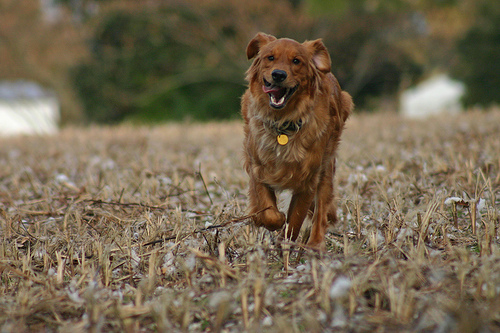

--------------------------Captions are--------------------------
startseq brown dog is running through brown field endseq
startseq brown dog is running through the field endseq
startseq brown dog with collar runs in the dead grass with his tongue hanging out to the side endseq
startseq brown dog with his tongue wagging as he runs through fie endseq
startseq dog running in the grass endseq
--------------------------Prediction is--------------------------
startseq  brown dog runs through the grass endseq


In [92]:
show_image_and_pred("69189650_6687da7280.jpg")

In [93]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 4096)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 34, 256)      2342144     ['input_20[0][0]']               
                                                                                                  
 dropout_16 (Dropout)           (None, 4096)         0           ['input_19[0][0]']               
                                                                                           